# Sentiment Analysis - IMDB Movie Review
Name: A P KRISHNA  
Roll. no: AM.EN.U4AIE21001

# Loading Libraries and Dataset

Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Packages

In [ ]:
import math, string, re
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

!pip install contractions
import contractions

sns.set_theme(style='dark', palette='crest')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading Dataset

In [ ]:
path = '/content/drive/MyDrive/Datasets/IMDB Dataset.csv'
imdb_df = pd.read_csv(path)

# Data Analysing

In [ ]:
imdb_df.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
imdb_df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
imdb_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

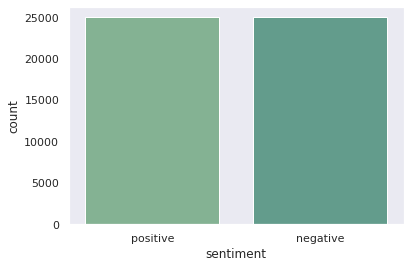

In [ ]:
sns.countplot(x ='sentiment', data = imdb_df)
plt.show()

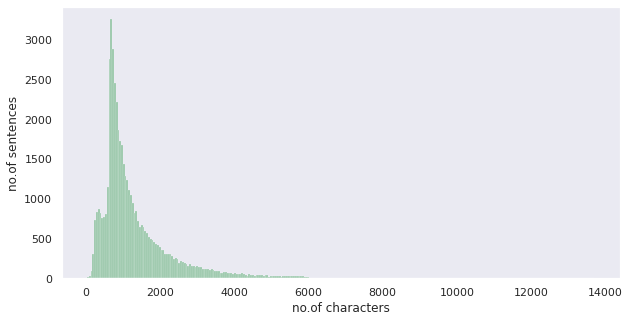

In [ ]:
plt.figure(figsize = (10,5))
text_len = imdb_df['review'].str.len()
sns.histplot(text_len)
plt.xlabel('no.of characters')
plt.ylabel('no.of sentences')
plt.show()

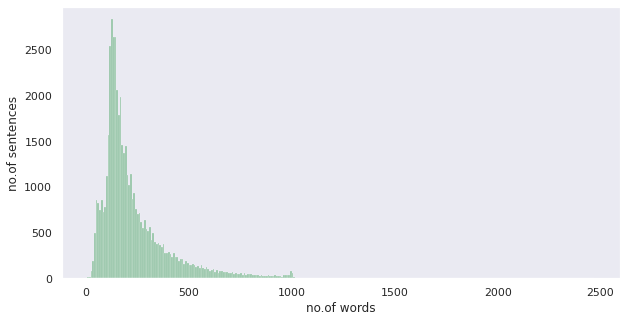

In [ ]:
plt.figure(figsize = (10,5))
text_len = imdb_df['review'].str.split().map(lambda x: len(x))
sns.histplot(text_len)
plt.xlabel('no.of words')
plt.ylabel('no.of sentences')
plt.show()

# Data Preprocessing and Visualisation

### Text Cleaning

In [ ]:
# function to convert text into lowercase
def lowercase_normalize(text):
    return text.lower()

# function to remove urls, @, html tags and punctuations
def remove_noise(text):
    res = ''
    res = re.sub(r'https?://\S+|www\.\S+|@\S+', '', text) # urls and @
    res = re.sub(r'<.*?>', '', res)                       # html tags
    res = re.sub(r'[^\w\s]', '', res)                     # punctuations
    return res

# function to remove extra white space
def remove_extra_space(text):
    return " ".join(text.split())

# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# function to remove stopwords
def remove_stopwords(text):
    STOP_WORDS = stopwords.words('english')
    res = " ".join([word for word in text.split() if word not in (STOP_WORDS)])
    return res

# function to expand contractions
def expand_contraction(text):
    text = contractions.fix(text)
    return text

# function to tokenize words
def tokenize_words(text):
    wd_tknr = WhitespaceTokenizer()
    return wd_tknr.tokenize(text)

# function to stem the text
def stem_words(text):
    stemmer = PorterStemmer()
    words = tokenize_words(text)
    res = ''
    for word in words:
        res = res + stemmer.stem(word) + ' '
    return res

# function to lemmatize the text
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    words = tokenize_words(text)
    res = ''
    for word in words:
        res = res + lemmatizer.lemmatize(word) + ' '
    return res

In [ ]:
imdb_df['review'] = imdb_df['review'].apply(lambda s : lowercase_normalize(s))
imdb_df['review'] = imdb_df['review'].apply(lambda s : expand_contraction(s))
imdb_df['review'] = imdb_df['review'].apply(lambda s : remove_noise(s))
imdb_df['review'] = imdb_df['review'].apply(lambda s : remove_stopwords(s))

In [ ]:
imdb_df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive


### Data Visualization

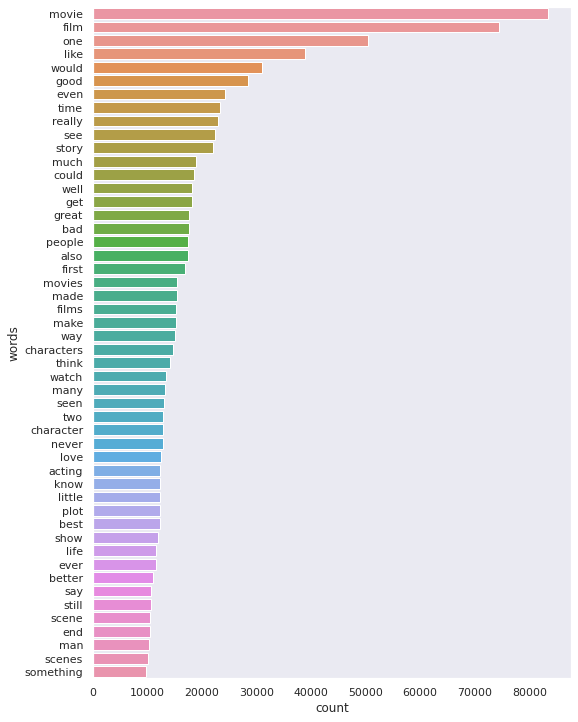

In [ ]:
corpus_plot = []
reviews_list = imdb_df['review'].str.split()
reviews_list = reviews_list.values.tolist()
corpus_plot = [word for i in reviews_list for word in i]
counter = Counter(corpus_plot)
most = counter.most_common()

x, y = [], []
for word,count in most[:50]:
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
sns.barplot(x=y,y=x)
plt.xlabel('count')
plt.ylabel('words')
plt.tight_layout(pad = 0.5)
plt.show()

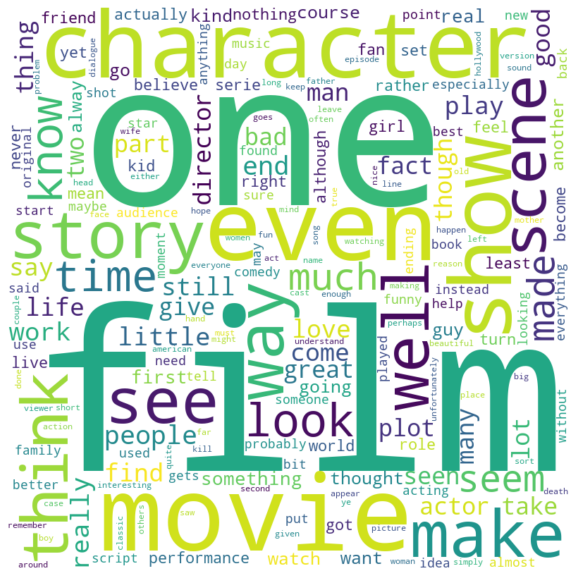

In [ ]:
text = ' '.join(s for s in imdb_df.review)
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0.5)
plt.show()

In [ ]:
df_negative = imdb_df[imdb_df['sentiment'] == 'negative']
df_positive = imdb_df[imdb_df['sentiment'] == 'positive']

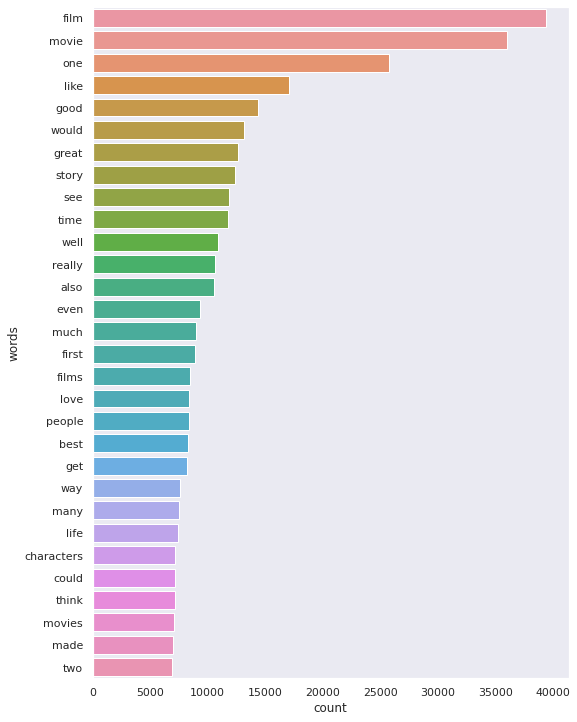

In [ ]:
corpus_plot = []
reviews_list = df_positive['review'].str.split()
reviews_list = reviews_list.values.tolist()
corpus_plot = [word for i in reviews_list for word in i]
counter = Counter(corpus_plot)
most = counter.most_common()

x, y = [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
sns.barplot(x=y,y=x)
plt.xlabel('count')
plt.ylabel('words')
plt.tight_layout(pad = 0.5)
plt.show()

In [ ]:
text_pos = ' '.join(s for s in df_positive.review)
wordcloud_pos = WordCloud(width = 800, height = 800, background_color ='white').generate(text_pos)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0.5)
plt.show()

In [ ]:
corpus_plot = []
reviews_list = df_negative['review'].str.split()
reviews_list = reviews_list.values.tolist()
corpus_plot = [word for i in reviews_list for word in i]
counter = Counter(corpus_plot)
most = counter.most_common()

x, y = [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
sns.barplot(x=y,y=x)
plt.xlabel('count')
plt.ylabel('words')
plt.tight_layout(pad = 0.5)
plt.show()

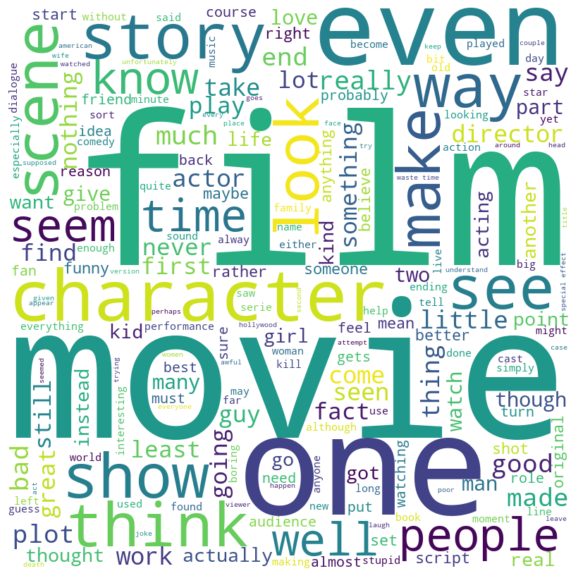

In [ ]:
text_neg = ' '.join(s for s in df_negative.review)
wordcloud_neg = WordCloud(width = 800, height = 800, background_color ='white').generate(text_neg)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0.5)
plt.show()

### Stemming Text

In [ ]:
imdb_df['review'] = imdb_df['review'].apply(lambda s : stem_words(s))

In [ ]:
imdb_df.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


### Data Encoding

In [ ]:
lb = LabelBinarizer()
imdb_df['sentiment'] = lb.fit_transform(imdb_df['sentiment'])

In [ ]:
imdb_df.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


### Word Vectorization

In [ ]:
X = imdb_df['review'].values
y = imdb_df['sentiment'].values

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', max_features = 3000)
X_cv = count_vectorizer.fit_transform(X).toarray()
vocab = count_vectorizer.get_feature_names_out()

In [ ]:
CVectorizedText = pd.DataFrame(X_cv, columns=count_vectorizer.get_feature_names_out())
CVectorizedText['Text']=pd.Series(imdb_df['review'])
CVectorizedText.head()

,10,100,1010,11,110,12,13,14,15,17,...,year,yell,york,young,younger,youth,zero,zombi,zone,Text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,one review mention watch 1 oz episod hook righ...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,wonder littl product film techniqu unassum old...
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,thought wonder way spend time hot summer weeke...
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,basic famili littl boy jake think zombi closet...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,petter mattei love time money visual stun film...


In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features = 3000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()
vocab = tfidf_vectorizer.get_feature_names_out()

In [ ]:
TfVectorizedText = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
TfVectorizedText['Text']=pd.Series(imdb_df['review'])
TfVectorizedText.head()

,10,100,1010,11,110,12,13,14,15,17,...,year,yell,york,young,younger,youth,zero,zombi,zone,Text
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,one review mention watch 1 oz episod hook righ...
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,wonder littl product film techniqu unassum old...
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071502,0.0,0.000000,0.086519,0.0,0.0,0.0,0.000000,0.0,thought wonder way spend time hot summer weeke...
3,0.086407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.124589,0.0,basic famili littl boy jake think zombi closet...
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.115236,0.000000,0.0,0.0,0.0,0.000000,0.0,petter mattei love time money visual stun film...


In [ ]:
# from google.colab import files
# imdb_df.to_csv('imdb_dataset_1.csv')
# files.download('imdb_dataset_1.csv')

# Validation and Prediction

### Splitting Dataset

In [ ]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y, test_size=0.20, random_state=6)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.20, random_state=16)

### K-Fold Cross Validation

In [ ]:
kf = KFold(n_splits=5)
nb_clf = MultinomialNB()
score_cv = cross_val_score(nb_clf, X_train_cv, y_train_cv, cv=kf)
score_tfidf = cross_val_score(nb_clf, X_train_tfidf, y_train_tfidf, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv)
print('Mean score(cv) - ', score_cv.mean())
print('CV scores(tfidf) - ', score_tfidf)
print('Mean score(tfidf) - ', score_tfidf.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.83275  0.842625 0.838375 0.850875 0.8345  ]
Mean score(cv) -  0.839825
CV scores(tfidf) -  [0.84325  0.843375 0.845    0.850125 0.841875]
Mean score(tfidf) -  0.8447250000000001


In [ ]:
kf = KFold(n_splits=5)
scaler = StandardScaler()
scaled_cv = scaler.fit_transform(X_train_cv)
scaled_tfidf = scaler.fit_transform(X_train_tfidf)
lg_clf = LogisticRegression(max_iter=150)
score_cv = cross_val_score(lg_clf, scaled_cv, y_train_cv, cv=kf)
score_tfidf = cross_val_score(lg_clf, scaled_tfidf, y_train_tfidf, cv=kf)
print('___Logistic Regression___')
print('CV scores(cv) - ', score_cv)
print('Mean score(cv) - ', score_cv.mean())
print('CV scores(tfidf) - ', score_tfidf)
print('Mean score(tfidf) - ', score_tfidf.mean())

___Logistic Regression___
CV scores(cv) -  [0.85925  0.86625  0.8595   0.86625  0.853375]
Mean score(cv) -  0.8609249999999999
CV scores(tfidf) -  [0.862    0.866125 0.858125 0.8655   0.8625  ]
Mean score(tfidf) -  0.8628499999999999


In [ ]:
kf = KFold(n_splits=5)
svc_clf = LinearSVC(max_iter=2000)
score_cv = cross_val_score(svc_clf, X_train_cv, y_train_cv, cv=kf)
score_tfidf = cross_val_score(svc_clf, X_train_tfidf, y_train_tfidf, cv=kf)
print('___Support Vector Classifer___')
print('CV scores(cv) - ', score_cv)
print('Mean score(cv) - ', score_cv.mean())
print('CV scores(tfidf) - ', score_tfidf)
print('Mean score(tfidf) - ', score_tfidf.mean())

___Support Vector Classifer___
CV scores(cv) -  [0.859125 0.867875 0.859375 0.867375 0.853125]
Mean score(cv) -  0.861375
CV scores(tfidf) -  [0.871    0.873875 0.866625 0.873    0.871375]
Mean score(tfidf) -  0.8711749999999998


### Prediction

In [ ]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_cv, y_train_cv)
nb_pred_cv = nb_clf.predict(X_test_cv)

nb_clf.fit(X_train_tfidf, y_train_tfidf)
nb_pred_tfidf = nb_clf.predict(X_test_tfidf)

Accuracy of Multinomial Naive Bayes(cv) -  0.8362


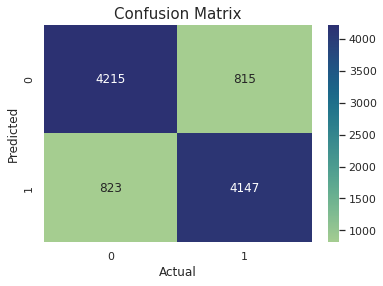

In [ ]:
print('Accuracy of Multinomial Naive Bayes(cv) - ', metrics.accuracy_score(y_test_cv, nb_pred_cv))
cf_matrix = confusion_matrix(y_test_cv, nb_pred_cv)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

Accuracy of Multinomial Naive Bayes(tfidf) -  0.8537


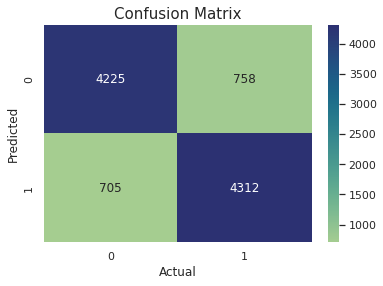

In [ ]:
print('Accuracy of Multinomial Naive Bayes(tfidf) - ', metrics.accuracy_score(y_test_tfidf, nb_pred_tfidf))
cf_matrix = confusion_matrix(y_test_tfidf, nb_pred_tfidf)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [ ]:
lg_clf = LogisticRegression(random_state = 0, max_iter=150)

scaled_cv_train = scaler.fit_transform(X_train_cv)
scaled_tfidf_train = scaler.fit_transform(X_train_tfidf)
scaled_cv_test = scaler.fit_transform(X_test_cv)
scaled_tfidf_test = scaler.fit_transform(X_test_tfidf)

lg_clf.fit(scaled_cv_train, y_train_cv)
lg_pred_cv = lg_clf.predict(scaled_cv_test)

lg_clf.fit(scaled_tfidf_train, y_train_tfidf)
lg_pred_tfidf = lg_clf.predict(scaled_tfidf_test)

Accuracy of Logistic Regression(cv) -  0.8645


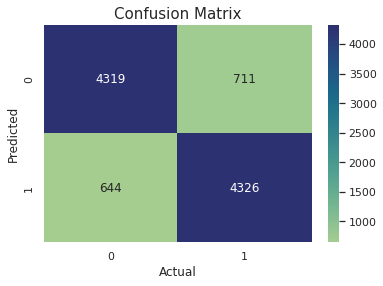

In [ ]:
print('Accuracy of Logistic Regression(cv) - ', metrics.accuracy_score(y_test_cv, lg_pred_cv))
cf_matrix = confusion_matrix(y_test_cv, lg_pred_cv)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

Accuracy of Logistic Regression(tfidf) -  0.8687


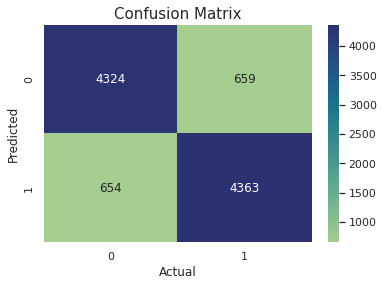

In [ ]:
print('Accuracy of Logistic Regression(tfidf) - ', metrics.accuracy_score(y_test_tfidf, lg_pred_tfidf))
cf_matrix = confusion_matrix(y_test_tfidf, lg_pred_tfidf)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [ ]:
svc_clf = LinearSVC(max_iter=2000)

svc_clf.fit(X_train_cv, y_train_cv)
svc_pred_cv = svc_clf.predict(X_test_cv)

svc_clf.fit(X_train_tfidf, y_train_tfidf)
svc_pred_tfidf = svc_clf.predict(X_test_tfidf)

Accuracy of SVC(cv) -  0.8651


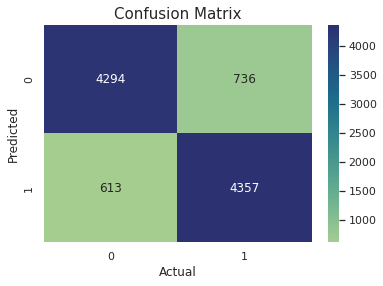

In [ ]:
print('Accuracy of SVC(cv) - ', metrics.accuracy_score(y_test_cv, svc_pred_cv))
cf_matrix = confusion_matrix(y_test_cv, svc_pred_cv)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

Accuracy of SVC(tfidf) -  0.8744


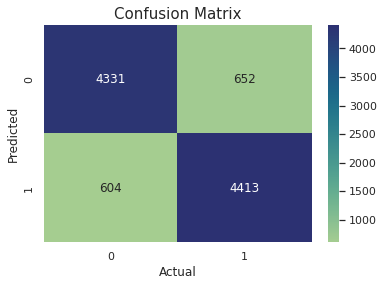

In [ ]:
print('Accuracy of SVC(tfidf) - ', metrics.accuracy_score(y_test_tfidf, svc_pred_tfidf))
cf_matrix = confusion_matrix(y_test_tfidf, svc_pred_tfidf)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt='d')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

Naive Bayes - 83.62
Logistic Regression - 86.45
Support Vector Classifier - 86.50999999999999


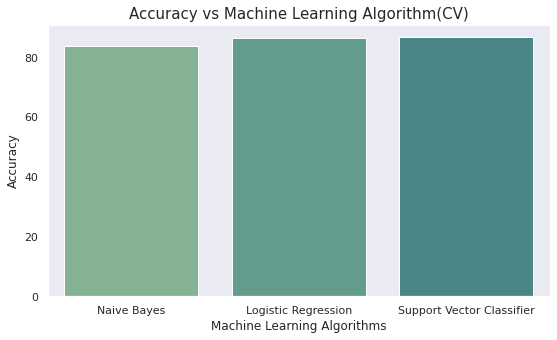

In [ ]:
acc_list=[]
acc_list.append(100*metrics.accuracy_score(y_test_cv, nb_pred_cv))
acc_list.append(100*metrics.accuracy_score(y_test_cv, lg_pred_cv))
acc_list.append(100*metrics.accuracy_score(y_test_cv, svc_pred_cv))
algo_list=['Naive Bayes', 'Logistic Regression', 'Support Vector Classifier']
for i in range(3):
  print(algo_list[i],'-',acc_list[i])
plt.figure(figsize=(9,5))
ax = sns.barplot(x=algo_list, y=acc_list)
plt.xlabel("Machine Learning Algorithms")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Machine Learning Algorithm(CV)", fontsize=15)
plt.show()

Naive Bayes - 85.37
Logistic Regression - 86.87
Support Vector Classifier - 87.44


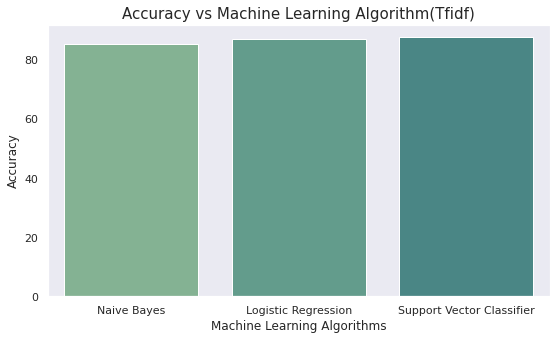

In [ ]:
acc_list=[]
acc_list.append(100*metrics.accuracy_score(y_test_tfidf, nb_pred_tfidf))
acc_list.append(100*metrics.accuracy_score(y_test_tfidf, lg_pred_tfidf))
acc_list.append(100*metrics.accuracy_score(y_test_tfidf, svc_pred_tfidf))
algo_list=['Naive Bayes', 'Logistic Regression', 'Support Vector Classifier']
for i in range(3):
  print(algo_list[i],'-',acc_list[i])
plt.figure(figsize=(9,5))
ax = sns.barplot(x=algo_list, y=acc_list)
plt.xlabel("Machine Learning Algorithms")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Machine Learning Algorithm(Tfidf)", fontsize=15)
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html ///content/PML_Dataset1_IMDB.ipynb